In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt

import re
import seaborn as sns
import datetime
from datetime import timedelta

Load data.

- Station Data
- Cleaned data of bike trips
- Cleaned data of YVR weather data

In [2]:
data_folder = 'data'
pickle_folder = 'pickle'

#load station data
station_info_df = pd.read_csv(data_folder + '/' + 'station_data.csv', dtype={'id': str, 'name': str, 'lat': float, 'lon': float, 'total_slots':int})

def load_pickle(url):
    '''
    Function to load pickle file
    '''
    infile = open(url, 'rb')
    data = pickle.load(infile)
    infile.close()
    return data

filename = 'mobi_cleaned.pkl'
combined_df = load_pickle(pickle_folder + '/' + filename)

filename = 'YVR_wxdata.pkl'
weather_df = load_pickle(pickle_folder + '/' + filename)

    

###  Start of DF assembly

In [3]:
date_range_ind = pd.date_range(start=datetime.date(2017, 1, 1), end=datetime.date(2019, 3, 31), freq='D')

In [4]:
def average_df(colname, df, time_freq='D'):
    '''
    Function to calculate the average based on the time frequency.
    '''
    
    target_df = df[colname]
    target_df.index = df['Date']

    output_target_df = target_df.resample(time_freq).sum()/target_df.resample(time_freq).count()
    
    return(output_target_df)


def max_df(colname, df, time_freq='D'):
    '''
    Function to calculate the average based on the time frequency.
    '''
    
    target_df = df[colname]
    target_df.index = df['Date']

    output_target_df = target_df.resample(time_freq).max()
       
    return(output_target_df)


def min_df(colname, df, time_freq='D'):
    '''
    Function to calculate the average based on the time frequency.
    '''
    
    target_df = df[colname]
    target_df.index = df['Date']

    output_target_df = target_df.resample(time_freq).min()

    return(output_target_df)


def sum_df(colname, df, time_freq='D'):
    '''
    Function to calculate the average based on the time frequency.
    '''
    
    target_df = df[colname]
    target_df.index = df['Date']

    output_target_df = target_df.resample(time_freq).sum()
    return(output_target_df)


In [5]:
df = pd.DataFrame({'count': [1] * len(combined_df['Departure'])})
df.index = combined_df['Departure']

df = df.resample('D').count()
#df['AVG_TEMP'] = temp_daily_avg_df
df = df[:-1]


var_list = ['CO', 'NO', 'NO2', 'O3', 'PM25', 'SO2', 'PM10', 'WSPD_SCLR',
       'WDIR_SCLR', 'WSPD_VECT', 'WDIR_VECT', 'TEMP_MEAN', 'ATM_PRESS_1HR',
       'HUMIDITY', 'RAD_TOTAL', 'PRECIP_TOTAL']


for var in var_list:
    df[('AVG_'+var)] = average_df(var, weather_df)

for var in ['TEMP_MEAN']:
    df[('MAX_'+var)] = max_df(var, weather_df)
    
for var in ['TEMP_MEAN']:
    df[('MIN_'+var)] = min_df(var, weather_df)

for var in ['TEMP_MEAN']:
    df[('RANGE_'+var)] = max_df(var, weather_df) - min_df(var, weather_df) 

    
df['SUM_PRECIP_TOTAL'] = sum_df('PRECIP_TOTAL', weather_df)

### Plotting the Correlation Matrix

First scale the data before doing the correlation matrix, or else it will be skewed.

The variables that are highly correlated to the trip counts in a day is the average temperature and the average solar irradiance. There is a theoretical equation in which the total and average solar irradiance can be calcuated, but this variables fluctuates with cloud cover and aerosol concentration in the air. 

From a practical perspective, temperature and precipitation are the only variables where we can reasonable rely on if we want to use forecast data from a weather model. 

For this project, I am going to make an assumption that the observation model that we use for the testing and validation are the same as the forecast data that is generated from a weather model. Usually, the data from a weather model that are 2-3 days out are quite reliable.

C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


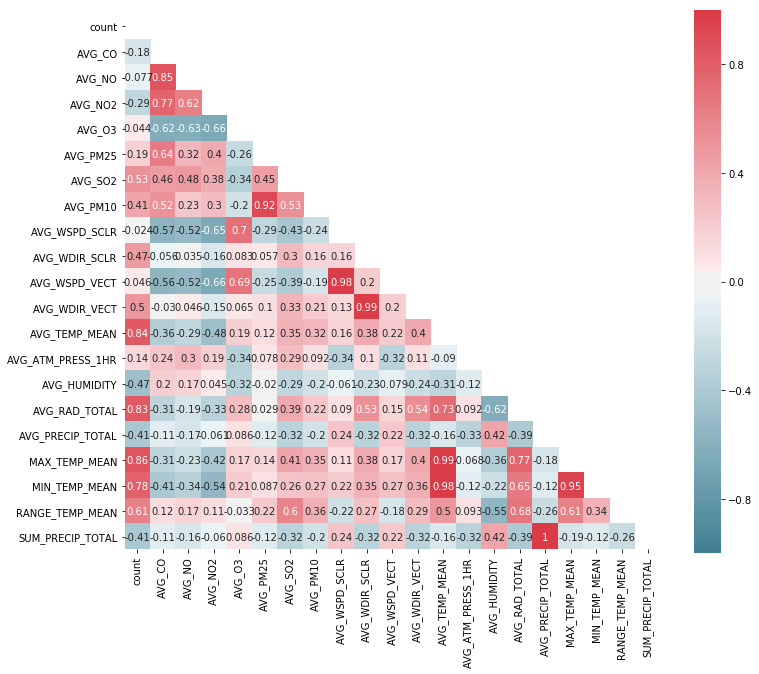

In [6]:
from sklearn.preprocessing import StandardScaler

def scale_data(df):
    scaler = StandardScaler()
    scaler.fit(df)
    scaled_df = scaler.transform(df)
    scaled_df = pd.DataFrame(scaled_df, columns=df.columns, index=df.index)
    return(scaled_df)

#scaled_df = scale_data(df)

plt.figure(figsize=(12,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#cmap = sns.color_palette("coolwarm", 100)

corr_df = scale_data(df).corr()

mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_df, mask = mask, annot=True, cmap=cmap, center=0, vmin=-1.0, vmax=1.0, square=True);

C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


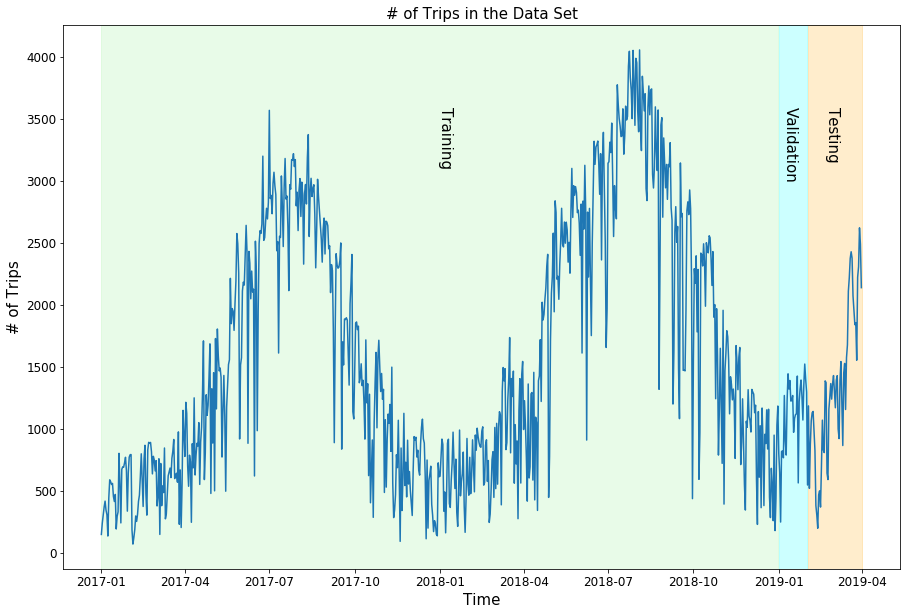

In [7]:
col = 'black'
a = 0.2
font_size_tick=12
plt.figure(figsize=(15,10))
plt.plot(df['count'], label='Count')
plt.xlabel('Time', fontsize=15, color=col)
plt.ylabel('# of Trips', fontsize=15, color=col)
plt.title('# of Trips in the Data Set',  fontsize=15, color=col)
plt.xticks(fontsize=font_size_tick, color=col)
plt.yticks(fontsize=font_size_tick, color=col)
plt.axvspan('2017-01-01', '2018-12-31', color='lightgreen', alpha=a)
plt.axvspan('2019-01-01', '2019-01-31', color='cyan', alpha=a)
plt.axvspan('2019-02-01', '2019-04-01', color='orange', alpha=a)
plt.annotate('Training', ('2017-12-30', 3500), fontsize=15, rotation=270)
plt.annotate('Validation', ('2019-01-05', 3500), fontsize=15, rotation=270)
plt.annotate('Testing', ('2019-02-20', 3500), fontsize=15, rotation=270)
plt.show();

### Adding Additional Features

#### Day of the Week

In [8]:
df['day_of_week']=df.index.to_series().dt.dayofweek

df.loc[df['day_of_week'] == 0, 'day_of_week'] = 'Monday'
df.loc[df['day_of_week'] == 1, 'day_of_week'] = 'Tuesday'
df.loc[df['day_of_week'] == 2, 'day_of_week'] = 'Wednesday'
df.loc[df['day_of_week'] == 3, 'day_of_week'] = 'Thursday'
df.loc[df['day_of_week'] == 4, 'day_of_week'] = 'Friday'
df.loc[df['day_of_week'] == 5, 'day_of_week'] = 'Saturday'
df.loc[df['day_of_week'] == 6, 'day_of_week'] = 'Sunday'

#### Holidays in BC

In [9]:
holiday_list = [datetime.datetime(2017, 1, 1),
    datetime.datetime(2017, 1, 2),
    datetime.datetime(2017, 2, 13),
    datetime.datetime(2017, 4, 14),
    datetime.datetime(2017, 5, 22),
    datetime.datetime(2017, 7, 1),
    datetime.datetime(2017, 8, 7),
    datetime.datetime(2017, 9, 4),
    datetime.datetime(2017, 10, 9),
    datetime.datetime(2017, 11, 10),
    datetime.datetime(2017, 11, 11),
    datetime.datetime(2017, 12, 24),
    datetime.datetime(2017, 12, 25),
    datetime.datetime(2017, 12, 26),
    datetime.datetime(2018, 1, 1),
    datetime.datetime(2018, 2, 12),
    datetime.datetime(2018, 3, 30),
    datetime.datetime(2018, 5, 21),
    datetime.datetime(2018, 7, 1),
    datetime.datetime(2018, 7, 2),
    datetime.datetime(2018, 8, 6),
    datetime.datetime(2018, 9, 3),
    datetime.datetime(2018, 10, 8),
    datetime.datetime(2018, 11, 11),
    datetime.datetime(2018, 11, 12),
    datetime.datetime(2018, 12, 24),
    datetime.datetime(2018, 12, 25),
    datetime.datetime(2018, 12, 26),
    datetime.datetime(2019, 1, 1),
    datetime.datetime(2019, 2, 18)
]
holiday_list = pd.to_datetime(holiday_list)

#convert to 1 and 0
holiday_col = date_range_ind.isin(holiday_list)

df['HOLIDAY'] = holiday_col.astype(int)
df['NOT_HOLIDAY'] = (~(holiday_col)).astype(int)

del holiday_list, holiday_col

#### Add Season

In [10]:
#from stack overflow
#https://stackoverflow.com/questions/16139306/determine-season-given-timestamp-in-python-using-datetime

def season_of_date(date):
    year = str(date.year)
    seasons = {'Spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'Summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'Autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['Spring']:
        return 'Spring'
    if date in seasons['Summer']:
        return 'Summer'
    if date in seasons['Autumn']:
        return 'Autumn'
    else:
        return 'Winter'
    
df['SEASON'] = date_range_ind.map(season_of_date)

#### Add Quarter, Weekday, Weekend


In [11]:
df['QUARTER'] = date_range_ind.quarter.astype(str)

df['Weekday'] = df['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']).astype(int)
df['Weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)

In [12]:
def model_score(model, X_train, X_valid, X_test, y_train, y_valid, y_test):
    '''
    Calculates the RMSE and R2 metrics
    '''
    
    import math
    from sklearn.metrics import r2_score, mean_squared_error

    score_output = [
        math.sqrt(mean_squared_error(y_train, model.predict(X_train).round())),
        math.sqrt(mean_squared_error(y_valid, model.predict(X_valid).round())),
        math.sqrt(mean_squared_error(y_test, model.predict(X_test).round())),
        r2_score(y_train, model.predict(X_train).round()),
        r2_score(y_valid, model.predict(X_valid).round()),
        r2_score(y_test, model.predict(X_test).round())
        ]
    
    return (score_output)

def model_score_alt(y_predictors, y_train, y_valid, y_test):
    '''
    Calculates the RMSE and R2 metrics. Used when we pass it a list of y_predictors
    '''
    
    import math
    from sklearn.metrics import r2_score, mean_squared_error

    score_output = [
        math.sqrt(mean_squared_error(y_train, y_predictors[0].round())),
        math.sqrt(mean_squared_error(y_valid, y_predictors[1].round())),
        math.sqrt(mean_squared_error(y_test, y_predictors[2].round())),
        r2_score(y_train, y_predictors[0].round()),
        r2_score(y_valid, y_predictors[1].round()),
        r2_score(y_test, y_predictors[2].round())
        ]
    
    return (score_output)


def custom_plot_package(model_name, model, X_train, X_valid, X_test, y_train, y_valid, y_test):

    '''
    Outputs plots for train, valid, and test
    
    In addition, it calls the model_score function that calculates the RMSE and R2
    '''
    
    plt.figure(figsize=(10,10))

    X_list = [X_train, X_valid, X_test]
    y_list = [y_train, y_valid, y_test]
    name_list = ['Training', 'Valid', 'Test']
    
    for i in range(3):
        plt.subplot(3,1, (i + 1))
        plt.plot(y_list[i], label='Actual')
        plt.plot(pd.DataFrame(model.predict(X_list[i]), index=y_list[i].index), label='Prediction')
        plt.legend()
        plt.title(model_name + ' - ' + name_list[i])
        plt.xlim(y_list[i].index[0], y_list[i].index[-1])

    model_score_list = model_score(model, X_train, X_valid, X_test, y_train, y_valid, y_test)
    
    return (model_score_list)


def custom_plot_package_alt(model_name, y_predictors, y_train, y_valid, y_test):

    '''
    Outputs plots for train, validation, and test
    
    In addition, it calls the model_score function that calculates the RMSE and R2.
    
    Only used if we pass this function the y_predictors
    '''
    
    plt.figure(figsize=(10,10))

    y_list = [y_train, y_valid, y_test]
    name_list = ['Training', 'Validation', 'Test']
    
    for i in range(3):
        plt.subplot(3,1, (i + 1))
        plt.plot(y_list[i], label='Actual')
        plt.plot(y_predictors[i], label='Prediction')
        plt.legend()
        plt.title(model_name + ' - ' + name_list[i])
        plt.xlim(y_list[i].index[0], y_list[i].index[-1])

    model_score_list = model_score_alt(y_predictors, y_train, y_valid, y_test)
    
    return (model_score_list)


def custom_score_display(the_score, index=None):
    
    '''
    If a list of index is provided, it will expect the first argument to be a list to create a combined score.
    '''

    if index is None:
        output_score  = pd.DataFrame([the_score])
    else:
        output_score = pd.DataFrame(the_score)
        output_score.index = index
    
    output_score.columns = ['Training - RMSE', 'Validation - RMSE', 'Test - RMSE', 'Training - R2', 'Valid - R2', 'Test - R2']
    
    return (output_score)

In [13]:
#Assemble df

X = df.reindex(['AVG_TEMP_MEAN', 'day_of_week', 'SUM_PRECIP_TOTAL', 'MAX_TEMP_MEAN', 'MIN_TEMP_MEAN',
                'HOLIDAY', 'NOT_HOLIDAY', 'SEASON', 'QUARTER', 'Weekday', 'Weekend'], axis=1)

y = df['count']

In [14]:
date_range_train = pd.date_range(start=datetime.date(2017, 1, 1), end=datetime.date(2018, 12, 31), freq='D')
date_range_valid = pd.date_range(start=datetime.date(2019, 1, 1), end=datetime.date(2019, 1, 31), freq='D')
date_range_test = pd.date_range(start=datetime.date(2019, 2, 1), end=datetime.date(2019, 3, 31), freq='D')

X_onehot = pd.get_dummies(X)

X_train = X_onehot.loc[date_range_train]
X_valid = X_onehot.loc[date_range_valid]
X_test = X_onehot.loc[date_range_test]

y_train = y.loc[date_range_train]
y_valid = y.loc[date_range_valid]
y_test = y.loc[date_range_test]

#For Statsmodel OLS
import statsmodels.api as sm
X_onehot_c = sm.add_constant(X_onehot)

X_train_c = X_onehot_c.loc[date_range_train]
X_test_c = X_onehot_c.loc[date_range_test]
X_valid_c = X_onehot_c.loc[date_range_valid]

C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [15]:
from statsmodels.regression import linear_model

lin_reg_model_sm = linear_model.OLS(y_train, X_train_c).fit()
lin_reg_model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     230.7
Date:                Thu, 29 Aug 2019   Prob (F-statistic):          7.51e-276
Time:                        19:42:53   Log-Likelihood:                -5418.3
No. Observations:                 730   AIC:                         1.087e+04
Df Residuals:                     712   BIC:                         1.096e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    89.3768     27.679      3.229      0.001      35.034     143.719
AVG_TEMP_MEAN           160.2056     45.364      3.532      0.000      71.142     249.269
SUM_PRECIP_TOTAL        -30.2747      2.159    -14.022      0.000     -34.513     -26.036
MAX_TEMP_MEAN            51.9079     24.315      2.135      0.033       4.170      99.646
MIN_TEMP_MEAN          -123.3256     23.920     -5.156      0.000    -170.288     -76.364
HOLIDAY                  17.5973     50.072      0.351      0.725     -80.710     115.904
NOT_HOLIDAY              71.7795     37.284      1.925      0.055      -1.421     144.980
Weekday                 104.2826     19.296      5.404      0.000      66.399     142.166
Weekend                 -14.9057     17.968     -0.830      0.407     -50.183      20.371
day_of_week_Friday       50.6270     36.198      1.399      0.162     -20.440     121.694
day_of_week_Monday      -35.5753     36.891     -0.964      0.335    -108.003      36.852
day_of_week_Saturday     72.4028     29.772      2.432      0.015      13.952     130.854
day_of_week_Sunday      -87.3085     29.813     -2.929      0.004    -145.840     -28.777
day_of_week_Thursday     53.8860     36.646      1.470      0.142     -18.062     125.834
day_of_week_Tuesday      30.6977     36.436      0.843      0.400     -40.837     102.233
day_of_week_Wednesday     4.6472     36.382      0.128      0.898     -66.782      76.076
SEASON_Autumn             7.9719     57.795      0.138      0.890    -105.497     121.441
SEASON_Spring          -141.6792     53.857     -2.631      0.009    -247.417     -35.942
SEASON_Summer           331.6684     62.950      5.269      0.000     208.079     455.258
SEASON_Winter          -108.5842     55.525     -1.956      0.051    -217.597       0.428
QUARTER_1              -111.2705     54.350     -2.047      0.041    -217.976      -4.565
QUARTER_2               100.4451     57.371      1.751      0.080     -12.191     213.081
QUARTER_3               104.8765     60.937      1.721      0.086     -14.762     224.515
QUARTER_4                -4.6743     57.580     -0.081      0.935    -117.720     108.372
==============================================================================
Omnibus:                        2.327   Durbin-Watson:                   0.876
Prob(Omnibus):                  0.312   Jarque-Bera (JB):                2.309
Skew:                           0.138   Prob(JB):                        0.315
Kurtosis:                       2.983   Cond. No.                     5.21e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.34e-30. This might indicate that there are


,Training - RMSE,Validation - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
0,404.757259,421.274793,558.745766,0.846386,-1.003925,0.175153


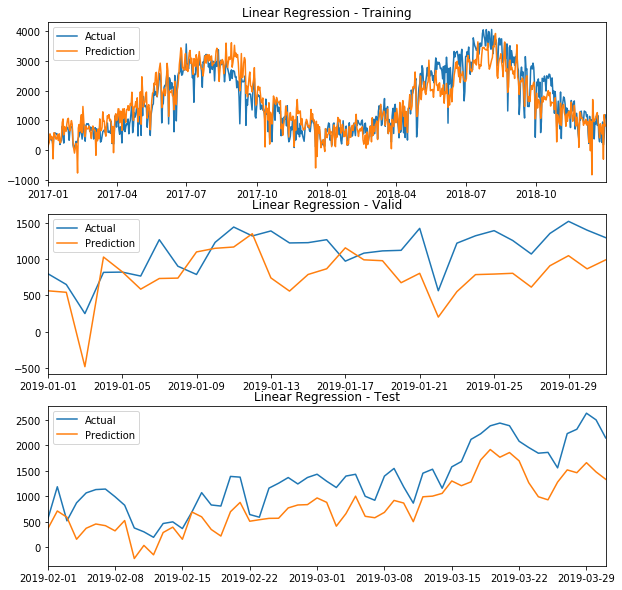

In [16]:
model_name = 'Linear Regression'
model = lin_reg_model_sm


lin_score = custom_plot_package('Linear Regression', lin_reg_model_sm, X_train_c, X_valid_c, X_test_c, y_train, y_valid, y_test)
custom_score_display(lin_score)

### Random Forest

In [17]:
from sklearn.ensemble import RandomForestRegressor

#RF_model =  RandomForestRegressor(n_estimators=50, max_depth = 4, oob_score=True, min_samples_leaf=5)
RF_model = RandomForestRegressor(n_estimators=50, max_depth=10, oob_score=False, n_jobs=-1)
RF_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

,Training - RMSE,Validation - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
0,184.215939,386.561392,479.769507,0.96818,-0.687281,0.391851


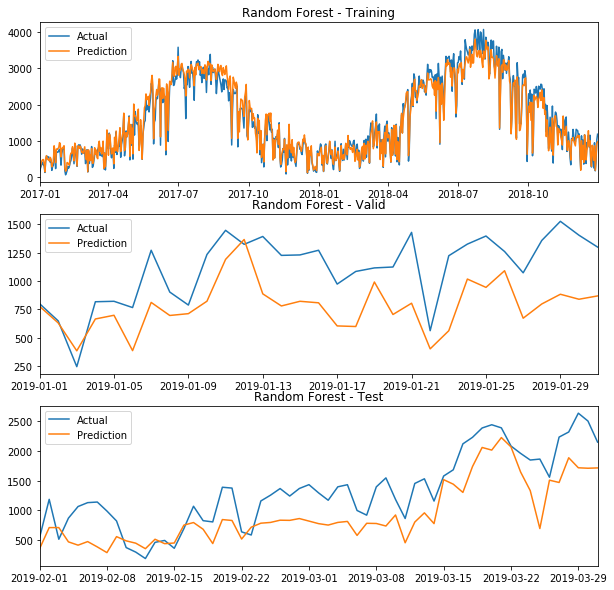

In [18]:
RF_score = custom_plot_package('Random Forest', RF_model, X_train, X_valid, X_test, y_train, y_valid, y_test)
custom_score_display(RF_score)

### XGBoost

In [19]:
from xgboost import XGBRegressor

XGB_model = XGBRegressor(learning_rate=.05, max_depth=4, 
                             n_estimators=200, gamma=0, 
                             subsample=0.9, colsample_bytree=0.7,
                             scale_pos_weight=1, min_child_weight=3,
                             reg_alpha=0.01)
XGB_model.fit(X_train, y_train)

[19:42:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\yauha\Anaconda3\envs\timeseries\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, gamma=0,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=3, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.9, verbosity=1)

,Training - RMSE,Validation - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
0,236.069992,377.174598,493.899273,0.947746,-0.606332,0.355502


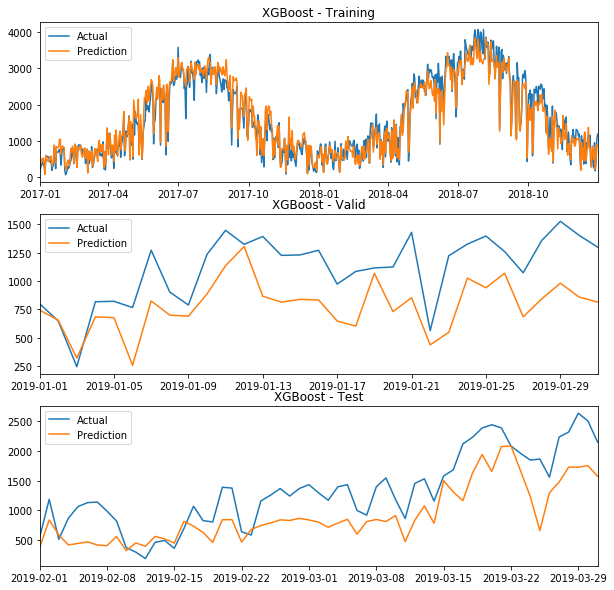

In [20]:
XGB_score = custom_plot_package('XGBoost', XGB_model, X_train, X_valid, X_test, y_train, y_valid, y_test)
custom_score_display(XGB_score)

### LightGBM

In [21]:
from lightgbm import LGBMRegressor

LGBM_model = LGBMRegressor(learning_rate=0.1,
                           max_depth=3, 
                           n_estimators=302, 
                           num_leaves=6,
                           reg_alpha=94,
                           reg_lambda=92
                          )
LGBM_model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=3,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=302, n_jobs=-1, num_leaves=6, objective=None,
       random_state=None, reg_alpha=94, reg_lambda=92, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

,Training - RMSE,Validation - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
0,302.574415,386.498466,473.081048,0.914157,-0.686732,0.408689


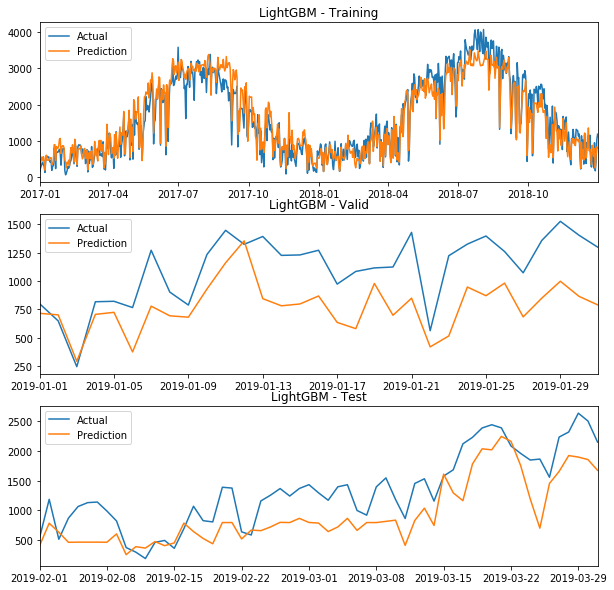

In [22]:
LGBM_score = custom_plot_package('LightGBM', LGBM_model, X_train, X_valid, X_test, y_train, y_valid, y_test)
custom_score_display(LGBM_score)

### CatBoost

In [23]:
from catboost import CatBoostRegressor
CB_model = CatBoostRegressor(learning_rate=0.01, 
                             max_depth=6, 
                             n_estimators=1500, 
                             l2_leaf_reg=4,
                             random_strength=0,
                             bagging_temperature=40,
                             task_type='GPU')

CB_model.fit(X_train, y_train)

0:	learn: 1904.2029591	total: 12.3ms	remaining: 18.4s
1:	learn: 1889.1047615	total: 23ms	remaining: 17.2s
2:	learn: 1874.1858214	total: 32.9ms	remaining: 16.4s
3:	learn: 1859.4447956	total: 42.8ms	remaining: 16s
4:	learn: 1844.8798662	total: 52.9ms	remaining: 15.8s
5:	learn: 1830.4895849	total: 62.9ms	remaining: 15.7s
6:	learn: 1816.2721177	total: 73ms	remaining: 15.6s
7:	learn: 1802.2259114	total: 83.2ms	remaining: 15.5s
8:	learn: 1788.3493147	total: 93.2ms	remaining: 15.4s
9:	learn: 1774.6410696	total: 104ms	remaining: 15.5s
10:	learn: 1759.0678478	total: 116ms	remaining: 15.7s
11:	learn: 1745.6681729	total: 126ms	remaining: 15.6s
12:	learn: 1732.4320635	total: 137ms	remaining: 15.7s
13:	learn: 1719.3575863	total: 150ms	remaining: 15.9s
14:	learn: 1706.4436270	total: 163ms	remaining: 16.2s
15:	learn: 1693.6885256	total: 175ms	remaining: 16.3s
16:	learn: 1681.0909439	total: 187ms	remaining: 16.3s
17:	learn: 1668.6490902	total: 200ms	remaining: 16.5s
18:	learn: 1656.3619219	total: 213m

155:	learn: 867.9864401	total: 1.69s	remaining: 14.5s
156:	learn: 866.4731726	total: 1.7s	remaining: 14.5s
157:	learn: 864.9872594	total: 1.71s	remaining: 14.5s
158:	learn: 860.6408062	total: 1.73s	remaining: 14.6s
159:	learn: 859.2017959	total: 1.74s	remaining: 14.5s
160:	learn: 857.7888363	total: 1.75s	remaining: 14.5s
161:	learn: 856.4014933	total: 1.76s	remaining: 14.5s
162:	learn: 855.0392765	total: 1.77s	remaining: 14.6s
163:	learn: 853.7017413	total: 1.79s	remaining: 14.6s
164:	learn: 850.0974577	total: 1.8s	remaining: 14.6s
165:	learn: 848.8024634	total: 1.82s	remaining: 14.6s
166:	learn: 847.5310670	total: 1.83s	remaining: 14.6s
167:	learn: 846.2828829	total: 1.84s	remaining: 14.6s
168:	learn: 841.6698862	total: 1.85s	remaining: 14.6s
169:	learn: 840.4637989	total: 1.87s	remaining: 14.6s
170:	learn: 839.2798217	total: 1.88s	remaining: 14.6s
171:	learn: 838.1174992	total: 1.89s	remaining: 14.6s
172:	learn: 836.9765549	total: 1.9s	remaining: 14.6s
173:	learn: 835.8566043	total: 

319:	learn: 702.3080228	total: 3.54s	remaining: 13.1s
320:	learn: 701.7518587	total: 3.55s	remaining: 13s
321:	learn: 701.6869223	total: 3.56s	remaining: 13s
322:	learn: 701.6232607	total: 3.57s	remaining: 13s
323:	learn: 700.6213133	total: 3.58s	remaining: 13s
324:	learn: 700.5601516	total: 3.59s	remaining: 13s
325:	learn: 699.6765437	total: 3.6s	remaining: 13s
326:	learn: 699.6176177	total: 3.61s	remaining: 13s
327:	learn: 699.5599713	total: 3.62s	remaining: 12.9s
328:	learn: 699.5033855	total: 3.63s	remaining: 12.9s
329:	learn: 699.4479545	total: 3.64s	remaining: 12.9s
330:	learn: 695.8234385	total: 3.66s	remaining: 12.9s
331:	learn: 695.4771142	total: 3.67s	remaining: 12.9s
332:	learn: 695.4248923	total: 3.68s	remaining: 12.9s
333:	learn: 695.3736750	total: 3.69s	remaining: 12.9s
334:	learn: 694.6951081	total: 3.7s	remaining: 12.9s
335:	learn: 694.6458248	total: 3.71s	remaining: 12.9s
336:	learn: 694.2713851	total: 3.72s	remaining: 12.8s
337:	learn: 692.4084629	total: 3.73s	remaini

486:	learn: 637.8972992	total: 5.39s	remaining: 11.2s
487:	learn: 637.8906678	total: 5.4s	remaining: 11.2s
488:	learn: 637.8466857	total: 5.41s	remaining: 11.2s
489:	learn: 637.8402256	total: 5.42s	remaining: 11.2s
490:	learn: 637.5754073	total: 5.43s	remaining: 11.2s
491:	learn: 637.5689788	total: 5.45s	remaining: 11.2s
492:	learn: 637.0891338	total: 5.46s	remaining: 11.1s
493:	learn: 637.0826316	total: 5.47s	remaining: 11.1s
494:	learn: 635.2650186	total: 5.48s	remaining: 11.1s
495:	learn: 635.2583942	total: 5.49s	remaining: 11.1s
496:	learn: 635.1630230	total: 5.5s	remaining: 11.1s
497:	learn: 635.1564320	total: 5.51s	remaining: 11.1s
498:	learn: 635.1499791	total: 5.53s	remaining: 11.1s
499:	learn: 634.8719901	total: 5.54s	remaining: 11.1s
500:	learn: 634.8657069	total: 5.55s	remaining: 11.1s
501:	learn: 634.8595616	total: 5.56s	remaining: 11.1s
502:	learn: 634.7817401	total: 5.58s	remaining: 11.1s
503:	learn: 634.7758357	total: 5.59s	remaining: 11s
504:	learn: 634.7700004	total: 5

648:	learn: 598.4429660	total: 7.24s	remaining: 9.5s
649:	learn: 596.4065176	total: 7.26s	remaining: 9.49s
650:	learn: 596.4014829	total: 7.27s	remaining: 9.48s
651:	learn: 596.0837672	total: 7.28s	remaining: 9.47s
652:	learn: 596.0400832	total: 7.29s	remaining: 9.46s
653:	learn: 596.0348799	total: 7.3s	remaining: 9.45s
654:	learn: 596.0297501	total: 7.31s	remaining: 9.44s
655:	learn: 596.0247122	total: 7.32s	remaining: 9.42s
656:	learn: 596.0197845	total: 7.33s	remaining: 9.41s
657:	learn: 595.9577626	total: 7.34s	remaining: 9.4s
658:	learn: 595.9151176	total: 7.35s	remaining: 9.38s
659:	learn: 595.9103178	total: 7.36s	remaining: 9.37s
660:	learn: 595.9056283	total: 7.37s	remaining: 9.36s
661:	learn: 595.9010123	total: 7.38s	remaining: 9.35s
662:	learn: 595.8964882	total: 7.39s	remaining: 9.34s
663:	learn: 595.8920561	total: 7.41s	remaining: 9.32s
664:	learn: 595.8398240	total: 7.42s	remaining: 9.31s
665:	learn: 595.8355202	total: 7.43s	remaining: 9.3s
666:	learn: 595.4267354	total: 7

811:	learn: 566.1823899	total: 9.1s	remaining: 7.71s
812:	learn: 566.1732926	total: 9.11s	remaining: 7.7s
813:	learn: 566.1682600	total: 9.12s	remaining: 7.69s
814:	learn: 566.0257025	total: 9.13s	remaining: 7.67s
815:	learn: 566.0019459	total: 9.14s	remaining: 7.66s
816:	learn: 565.9106469	total: 9.15s	remaining: 7.65s
817:	learn: 565.9055345	total: 9.17s	remaining: 7.64s
818:	learn: 565.9005382	total: 9.18s	remaining: 7.63s
819:	learn: 565.8761760	total: 9.19s	remaining: 7.62s
820:	learn: 565.8522001	total: 9.2s	remaining: 7.61s
821:	learn: 564.9874577	total: 9.21s	remaining: 7.59s
822:	learn: 564.9433091	total: 9.22s	remaining: 7.58s
823:	learn: 564.9383043	total: 9.23s	remaining: 7.57s
824:	learn: 564.9333771	total: 9.24s	remaining: 7.56s
825:	learn: 564.9104669	total: 9.25s	remaining: 7.55s
826:	learn: 564.9057528	total: 9.26s	remaining: 7.53s
827:	learn: 564.8506555	total: 9.27s	remaining: 7.52s
828:	learn: 564.8460767	total: 9.28s	remaining: 7.51s
829:	learn: 564.8415950	total: 

975:	learn: 539.4549659	total: 11s	remaining: 5.88s
976:	learn: 539.4489324	total: 11s	remaining: 5.87s
977:	learn: 539.4414361	total: 11s	remaining: 5.86s
978:	learn: 539.0308096	total: 11s	remaining: 5.84s
979:	learn: 539.0188956	total: 11s	remaining: 5.83s
980:	learn: 538.4032201	total: 11s	remaining: 5.82s
981:	learn: 538.3163810	total: 11s	remaining: 5.81s
982:	learn: 538.2996263	total: 11s	remaining: 5.8s
983:	learn: 538.2933559	total: 11s	remaining: 5.79s
984:	learn: 538.2863728	total: 11.1s	remaining: 5.78s
985:	learn: 538.2802041	total: 11.1s	remaining: 5.77s
986:	learn: 537.2000673	total: 11.1s	remaining: 5.76s
987:	learn: 537.1933557	total: 11.1s	remaining: 5.75s
988:	learn: 537.1867459	total: 11.1s	remaining: 5.74s
989:	learn: 537.0708991	total: 11.1s	remaining: 5.72s
990:	learn: 537.0595334	total: 11.1s	remaining: 5.71s
991:	learn: 537.0435150	total: 11.1s	remaining: 5.7s
992:	learn: 537.0371075	total: 11.1s	remaining: 5.69s
993:	learn: 536.9480065	total: 11.2s	remaining: 

1139:	learn: 515.8333383	total: 12.8s	remaining: 4.04s
1140:	learn: 515.6645187	total: 12.8s	remaining: 4.03s
1141:	learn: 515.6584194	total: 12.8s	remaining: 4.02s
1142:	learn: 515.6495996	total: 12.8s	remaining: 4.01s
1143:	learn: 515.6409922	total: 12.8s	remaining: 4s
1144:	learn: 515.5972093	total: 12.9s	remaining: 3.98s
1145:	learn: 515.5954239	total: 12.9s	remaining: 3.97s
1146:	learn: 515.5868793	total: 12.9s	remaining: 3.96s
1147:	learn: 515.5649647	total: 12.9s	remaining: 3.95s
1148:	learn: 515.5566110	total: 12.9s	remaining: 3.94s
1149:	learn: 514.1923098	total: 12.9s	remaining: 3.93s
1150:	learn: 514.0165340	total: 12.9s	remaining: 3.92s
1151:	learn: 513.3622716	total: 13s	remaining: 3.91s
1152:	learn: 513.3530495	total: 13s	remaining: 3.9s
1153:	learn: 512.4997989	total: 13s	remaining: 3.89s
1154:	learn: 512.4982165	total: 13s	remaining: 3.88s
1155:	learn: 512.4885939	total: 13s	remaining: 3.87s
1156:	learn: 512.4870329	total: 13s	remaining: 3.86s
1157:	learn: 512.4776454	t

1303:	learn: 494.4406332	total: 14.7s	remaining: 2.21s
1304:	learn: 494.4400569	total: 14.7s	remaining: 2.19s
1305:	learn: 494.3925566	total: 14.7s	remaining: 2.18s
1306:	learn: 494.1371115	total: 14.7s	remaining: 2.17s
1307:	learn: 494.1351820	total: 14.7s	remaining: 2.16s
1308:	learn: 494.1020692	total: 14.7s	remaining: 2.15s
1309:	learn: 494.0933083	total: 14.8s	remaining: 2.14s
1310:	learn: 493.9387350	total: 14.8s	remaining: 2.13s
1311:	learn: 493.9298603	total: 14.8s	remaining: 2.12s
1312:	learn: 493.9134859	total: 14.8s	remaining: 2.1s
1313:	learn: 493.8847517	total: 14.8s	remaining: 2.09s
1314:	learn: 493.7329099	total: 14.8s	remaining: 2.08s
1315:	learn: 493.6541299	total: 14.8s	remaining: 2.07s
1316:	learn: 493.6513550	total: 14.8s	remaining: 2.06s
1317:	learn: 493.6511774	total: 14.8s	remaining: 2.05s
1318:	learn: 493.6420088	total: 14.8s	remaining: 2.04s
1319:	learn: 493.6214733	total: 14.9s	remaining: 2.03s
1320:	learn: 493.6209405	total: 14.9s	remaining: 2.01s
1321:	learn

1461:	learn: 480.6967318	total: 16.5s	remaining: 429ms
1462:	learn: 480.6966634	total: 16.5s	remaining: 418ms
1463:	learn: 480.4337766	total: 16.5s	remaining: 407ms
1464:	learn: 480.4336854	total: 16.6s	remaining: 396ms
1465:	learn: 480.4266141	total: 16.6s	remaining: 384ms
1466:	learn: 480.4161666	total: 16.6s	remaining: 373ms
1467:	learn: 480.4160982	total: 16.6s	remaining: 362ms
1468:	learn: 480.3854617	total: 16.6s	remaining: 350ms
1469:	learn: 480.3852335	total: 16.6s	remaining: 339ms
1470:	learn: 480.3750361	total: 16.6s	remaining: 328ms
1471:	learn: 480.3650438	total: 16.6s	remaining: 316ms
1472:	learn: 480.3552567	total: 16.6s	remaining: 305ms
1473:	learn: 480.3551882	total: 16.7s	remaining: 294ms
1474:	learn: 480.3551426	total: 16.7s	remaining: 282ms
1475:	learn: 480.3422524	total: 16.7s	remaining: 271ms
1476:	learn: 480.3326473	total: 16.7s	remaining: 260ms
1477:	learn: 480.3198021	total: 16.7s	remaining: 249ms
1478:	learn: 480.3154215	total: 16.7s	remaining: 237ms
1479:	lear

,Training - RMSE,Validation - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
0,478.56446,262.121124,375.74615,0.785256,0.224192,0.626978


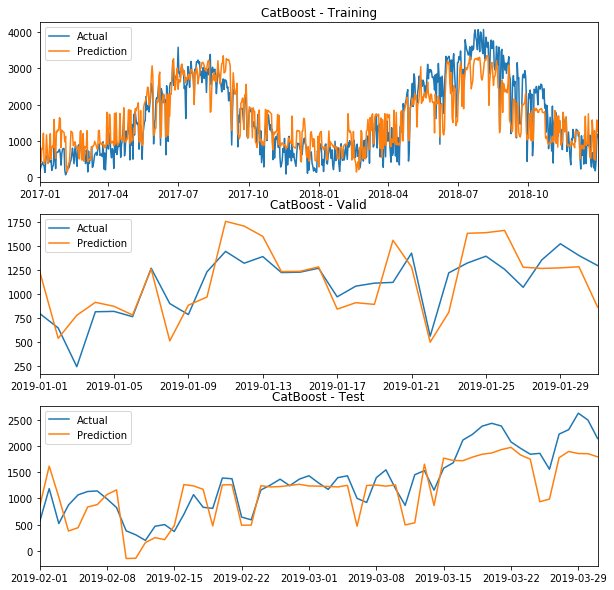

In [24]:
CB_score = custom_plot_package('CatBoost', CB_model, X_train, X_valid, X_test, y_train, y_valid, y_test)
custom_score_display(CB_score)

In [25]:
custom_score_display([lin_score, RF_score, XGB_score, LGBM_score, CB_score], 
                     index=['Lin Reg', 'RF', 'XGB', 'LightGBM', 'CatBoost'])

,Training - RMSE,Validation - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
Lin Reg,404.757259,421.274793,558.745766,0.846386,-1.003925,0.175153
RF,184.215939,386.561392,479.769507,0.968180,-0.687281,0.391851
XGB,236.069992,377.174598,493.899273,0.947746,-0.606332,0.355502
LightGBM,302.574415,386.498466,473.081048,0.914157,-0.686732,0.408689
CatBoost,478.564460,262.121124,375.746150,0.785256,0.224192,0.626978


In [26]:
def predict_combined_model(X_list, X_c_list):
    
    '''
    Best model average
    '''
    
    output_df = []
    
    for i in range(3):
        out_y_predictors = pd.DataFrame({
                                'XGBoost': XGB_model.predict(X_list[i])*2,
                                'Linear_Model': lin_reg_model_sm.predict(X_c_list[i]),
                                'CatBoost': CB_model.predict(X_list[i]),
                                 })
        
        df_avg = pd.DataFrame({'Value': out_y_predictors.mean(axis=1)})
        df_avg.index = X_list[i].index
        output_df.append(df_avg)
        
    return output_df

y_combined_model = predict_combined_model(X_list=[X_train, X_valid, X_test], 
                       X_c_list=[X_train_c, X_valid_c, X_test_c])

,Training - RMSE,Validation - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
0,656.446938,197.179139,251.242101,0.595946,0.560992,0.833225


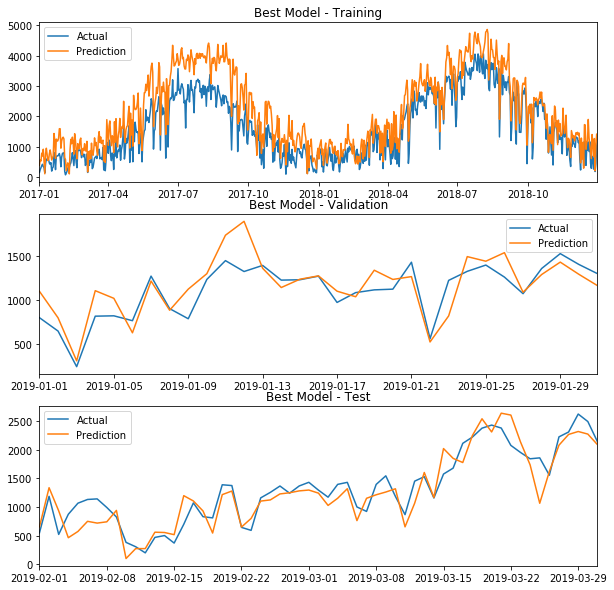

In [27]:
best_model_score = custom_plot_package_alt('Best Model', y_combined_model, y_train, y_valid, y_test)
custom_score_display(best_model_score)

In [28]:
custom_score_display([lin_score, RF_score, XGB_score, LGBM_score, CB_score, best_model_score], 
                     index=['Lin Reg', 'RF', 'XGB', 'LightGBM', 'CatBoost', 'Best Model'])

,Training - RMSE,Validation - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
Lin Reg,404.757259,421.274793,558.745766,0.846386,-1.003925,0.175153
RF,184.215939,386.561392,479.769507,0.968180,-0.687281,0.391851
XGB,236.069992,377.174598,493.899273,0.947746,-0.606332,0.355502
LightGBM,302.574415,386.498466,473.081048,0.914157,-0.686732,0.408689
CatBoost,478.564460,262.121124,375.746150,0.785256,0.224192,0.626978
Best Model,656.446938,197.179139,251.242101,0.595946,0.560992,0.833225
